In [3]:
!pip install neuromancer

In [12]:
import neuromancer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from neuromancer.psl.building_envelope import BuildingEnvelope
import functools
from neuromancer.dataset import DictDataset
from tqdm import tqdm
import random
from torch import tensor
import torch
from neuromancer.psl.signals import signals
import numpy as np
from torch.utils.data import DataLoader
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dynamics.integrators import RK4
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.loggers import BasicLogger
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import yaml
from dpc_util import simulate, stack_refs, load_stats, remove_key_prefix

In [13]:
# remove problematic signal
if 'beta' in signals:
  del signals['beta']

# set the seed
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Objective
This tutorial will show the usage of a Long Short-Term Memory network (LSTM) in neuromancer. LSTMs are a type of Recurrent Neural Network (RNN) architecture designed to handle long-term dependencies in sequence data. The original paper can be found [here](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).

We begin by making some modifications to `BuildingEnvelope`. We remove `@cast_backend` from `get_q` to enable gradient tracking (this is a bug with the psl systems).

In [14]:
class GradBuildingEnvelope(BuildingEnvelope):
    def __init__(self, device=None, *args, **kwargs):
        self.device=device
        super().__init__(*args, **kwargs)

    def get_q(self, u):
        m_flow = u[0:self.n_mf]
        dT = u[self.n_mf:self.n_mf + self.n_dT]
        q = m_flow * self.rho * self.cp * self.time_reg * dT
        return q

systems = {system: functools.partial(GradBuildingEnvelope, system=system) for system in BuildingEnvelope.systems}

Choose a system. On the problem of System identification, the LSTM class has only been observed to outperform NODEs on Reno_full when trained with sufficient data for long periods of time; excellent performance will likely not be seen in this notebook.

In [15]:
# supported systems: ['SimpleSingleZone', 'Reno_full']
psl_key = 'SimpleSingleZone'
psl_sys = systems[psl_key]()

# select appropriate device for runtime
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Learning an LSTM Neural State Space Model of a SimpleSingleZone

Define the LSTM class.

In [16]:
class LSTM(blocks.Block):
    """
    Contributors:
    - @Seth1Briney
    - @HarryLTS
    - @diego-llanes
    """
    def __init__(
            self,
            insize,
            outsize,
            hidden_size,
            num_layers=1,
            bias=True,
            dropout=0.0
    ):
        """
        insize (int): The size of each input feature vector.
        outsize (int): The size of each output feature vector.
        hidden_size (int): The number of features in the hidden state of each LSTM cell.
        num_layers (int, optional): The number of recurrent layers. Defaults to 1.
        bias (bool, optional): If `True`, adds a learnable bias to the output. Defaults to True.
        dropout (float, optional): If non-zero, introduces a dropout layer on the outputs of each
                                   LSTM layer except the last layer, with dropout probability equal
                                   to the value specified. Defaults to 0.0.
        """
        super().__init__()
        self.in_features, self.out_features = insize, outsize

        self.lstm = torch.nn.LSTM(
            input_size=insize,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bias=bias,
            batch_first=True,
            dropout=dropout,
            bidirectional=False,
            device=None,
            dtype=None)

        self.fc = torch.nn.Linear(hidden_size, outsize)

        self.h, self.c = None, None

    def reset(self):
        """
        Resets the internal states (hidden state and cell state) of the LSTM module.
        This should be called at the beginning of a sequence. You can use this with the neuromancer System class
        like this:

        ssm = LSTM(args)
        system_node = Node(ssm, ["yn", "U", "D"], ["yn"])
        def reset(data):
            system_node.callable.reset()
            return data
        init_fn = reset if args.architecture in ['LSTM', 'LSTM_integrator'] else None

        system = System([system_node], init_func=init_fn)
        """
        self.h, self.c = None, None

    def block_eval(self, x):
        """
        Processes the input sequence through the LSTM and outputs the transformed final state.

        Parameters:
            x (torch.Tensor): Input tensor of shape [batch_size, n_steps, dim] where `n_steps` is the
                              number of timesteps in each sequence, and `dim` is the dimensionality of
                              each timestep. If the tensor is 2D (batch_size, dim), it will be reshaped
                              to 3D assuming n_steps = 1.

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, outsize] representing the transformed
                          output of the final hidden state of the LSTM.
        """
        if len(x.shape) == 2:
            x = torch.unsqueeze(x, 1)

        x, (self.h, self.c) = self.lstm(x, (self.h, self.c) if self.h is not None else None)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

Initialize the system to work with the LSTM. Since hidden and cell states are tracked internally, they must be reset after each pass through the system. We accomplish this by overriding the `init` function of `System`.

In [6]:
ny, nu, nd = psl_sys.ny, psl_sys.nU, psl_sys.nD_obs
hsize = 128
nlayers = 2
ssm = LSTM(ny + nu + nd, ny, hsize, num_layers=nlayers)
system_node = Node(ssm, ["yn", "U", "D"], ["yn"])

def reset(data):
    system_node.callable.reset()
    return data
system = System([system_node], name='NSSM', init_func=reset).to(device)
system.nstep_key = 'Y'

Set up the problem.

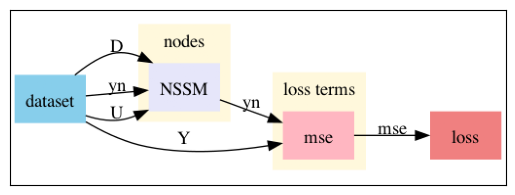

In [7]:
xpred = variable('yn')[:, :-1, :]
xtrue = variable('Y')

loss = (xpred == xtrue) ^ 2
loss.update_name('mse')

obj = PenaltyLoss([loss], [])
problem = Problem([system], obj).to(device)
problem.show()

## Dataset
We will train the LSTM on a dataset of sample simulations in the form of input-output-disturbance tuples:
$$\big[({y}^i_0, u^i_0, d^i_0), ..., ({y}^i_N, u^i_N, d^i_N) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the simulation length, $m$ represents number of simulations, and $i$ represents the index of the simulation.
Variables $y_k$ represent observable system states, $d_k$ are system disturbances, and $u_k$ are exogenous inputs at time $k$.


In [8]:
class StridedDataset(Dataset):
    """
    Strided Sequence Dataset compatible with neuromancer Trainer

    This dataset generates subsequences of a fixed length from a sequence dataset.
    The goal is to decouple the prediction horizon length from the length of the rollout.
    This is useful as a form of data augmentation.

    Contributors:
        - @Seth1Briney
        - @HarryLTS
        - @diego-llanes
    """

    def __init__(self, datadict, L=32, name='train', stride=1, update_fn=None):
        """
        :rtype: object
        :param datadict: (dict {str: Tensor}) Dictionary of tensors with shape (N, T, D)
        :param name: (str) Name of dataset
        :param L (int) Length of each subsequence
        :param stride (int) Stride between subsequences
        :param update_fn (callable) Function to collect the first element of the sequence for a rollout of predictions
        :example of update_fn: lambda d: d["yn"] = d["Y"][0:1, :]
        """
        super().__init__()
        self.datadict = datadict
        self.L = L
        self.name = name
        self.nsim, self.nsteps, _ = next(iter(datadict.values())).shape
        self.seqs_per_sim = self.nsteps - self.L + 1
        self.length = (self.nsim * self.seqs_per_sim) // stride
        self.update_fn = update_fn
        self.stride = stride

    def __getitem__(self, i):
        """Fetch a single item from the dataset."""
        i_sim, i = self.remainder(i * self.stride, self.seqs_per_sim)
        sim_chunk = {k: v[i_sim][i: i+self.L] for k, v in self.datadict.items()}
        if self.update_fn:
            self.update_fn(sim_chunk)
        return sim_chunk

    def __len__(self):
        return self.length

    def collate_fn(self, batch):
        """Wraps the default PyTorch batch collation function and adds a name field.

        :param batch: (dict str: torch.Tensor) dataset sample.
        """
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch

    def remainder(self, n, d):
        """ use the remainder algorithm to index sequences
        :param i (int) index of subsequence
        """
        i_sim = n // d
        i = n % d
        return i_sim, i

 We normalize $(y, u, d)$ based on saved normalization constants.

In [9]:
NV = load_stats(psl_sys, psl_key)
NVD = {k: v.to(device) for k, v in NV.items()}

We define the function for generating the dataset, as well as functions for using the normalization constants previously loaded.

In [10]:
def denorm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return normer[f'{key}_min'] + (normer[f'{key}_max'] - normer[f'{key}_min']) * (x+1)/2

def norm(x, key, cpu=True):
  normer = NV if cpu else NVD
  return 2 * (x - normer[f'{key}_min']) / (normer[f'{key}_max'] - normer[f'{key}_min']) - 1

def get_dataset(name, nsim=20, nsteps=3500, L=512, stride=509, device='cpu'):
    data = simulate(psl_sys, NV, nsim=nsim, nsteps=nsteps)
    def update_yn(d):
        d['yn'] = d['Y'][0:1, :].clone().detach().requires_grad_(True)

    if name == 'train':
        return StridedDataset(
            {
                'Y': norm(data['Y'], 'Y').to(device),
                'U': norm(data['U'], 'U').to(device),
                'D': norm(data['D'], 'D').to(device)
            },
            name=name,
            update_fn=update_yn,
            L=L,
            stride=stride
        )
    else:
        return DictDataset(
            {
                'yn': norm(data['Y'][:, 0:1, :], 'Y'),
                'Y': norm(data['Y'], 'Y').to(device),
                'U': norm(data['U'], 'U').to(device),
                'D': norm(data['D'], 'D').to(device)
            },
            name=name
        )

Finally, we initialize a training and development dataset.

In [11]:
train_data = get_dataset('train', nsim=100, device=device)
dev_data = get_dataset('dev', nsim=20, device=device)

Building data...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]


Initialize some dataloaders. These will be used in the Training step.

In [16]:
train_loader = DataLoader(
    train_data,
    batch_size=128,
    collate_fn=train_data.collate_fn,
    shuffle=True
)

dev_loader = DataLoader(
    dev_data,
    batch_size=128,
    collate_fn=dev_data.collate_fn,
    shuffle=False
)

## Train the LSTM

In [17]:
logger = BasicLogger(savedir='ssm_out', stdout=['train_loss', 'dev_loss'], verbosity=1)

# initialize optimizer and trainer
opt = optim.Adam(system.parameters(), 1e-3)
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=opt,
    epochs=20,
    patience=10,
    logger=logger,
    train_metric="train_loss",
    eval_metric="dev_loss",
    lr_scheduler=True,
    device=device
)

None
Number of parameters: 200833


In [18]:
# train the model
best_model = trainer.train()
trainer.model.load_state_dict(best_model)
problem.to("cpu")

epoch: 0	train_loss: 0.29505	dev_loss: 0.21093	eltime:  13.14146
epoch: 1	train_loss: 0.20710	dev_loss: 0.19869	eltime:  25.81529
epoch: 2	train_loss: 0.20360	dev_loss: 0.18932	eltime:  39.06913
epoch: 3	train_loss: 0.17017	dev_loss: 0.17464	eltime:  50.83692
epoch: 4	train_loss: 0.12157	dev_loss: 0.16586	eltime:  63.17106
epoch: 5	train_loss: 0.22812	dev_loss: 0.16348	eltime:  75.17733
epoch: 6	train_loss: 0.19232	dev_loss: 0.16306	eltime:  88.25495
epoch: 7	train_loss: 0.15433	dev_loss: 0.16199	eltime:  108.02836
epoch: 8	train_loss: 0.16070	dev_loss: 0.15584	eltime:  121.60169
epoch: 9	train_loss: 0.14632	dev_loss: 0.15066	eltime:  135.14234
epoch: 10	train_loss: 0.13722	dev_loss: 0.14571	eltime:  148.79853
epoch: 11	train_loss: 0.12415	dev_loss: 0.13688	eltime:  161.17326
epoch: 12	train_loss: 0.13268	dev_loss: 0.13360	eltime:  174.78977
epoch: 13	train_loss: 0.15399	dev_loss: 0.13443	eltime:  187.49581
epoch: 14	train_loss: 0.13050	dev_loss: 0.14117	eltime:  202.49964
epoch: 15	tr

### MODEL SUMMARY ###

nodeS:
  System(
  (nodes): ModuleList(
    (0): node_1(yn, U, D) -> yn
  )
)

CONSTRAINTS: none

OBJECTIVES:
  Constraint(
  (left): slice
  (right): Y
  (comparator): Eq()
)

## Evaluation

Now that we have trained the LSTM, we can visualize its accuracy by comparing the output $\hat{y}$ it to the reference $y$.

In [19]:
# evaluate the system
test_data_dict = get_dataset('test', nsim=5).datadict
system_node.eval()
test_out = system(test_data_dict)

# discard last predicted state
test_out['yn'] = test_out['yn'][:, :-1, :]

Building data...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


<Figure size 640x480 with 0 Axes>

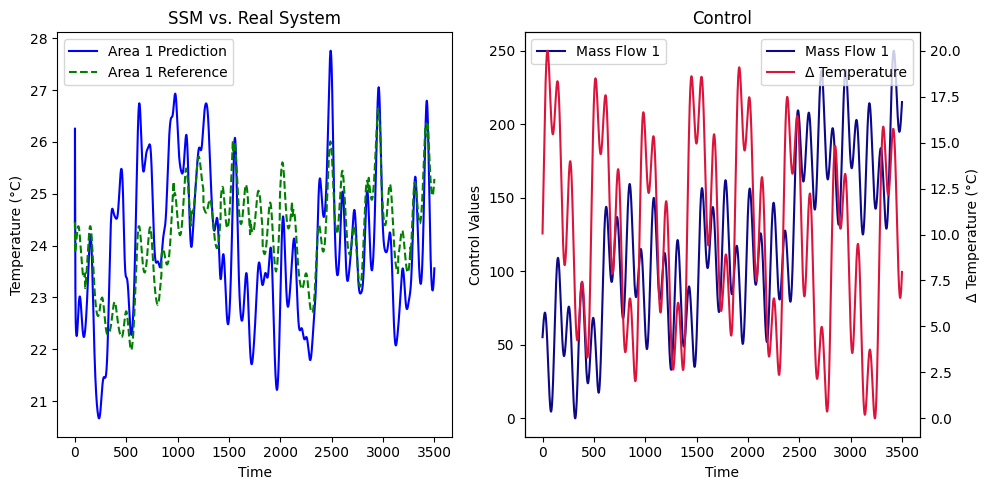

In [20]:
import matplotlib.pyplot as plt

def plot_sysid(data, sim=0):
    num_colors = 6
    pred_colors = [plt.cm.winter(i / num_colors) for i in range(num_colors)]
    target_colors = [plt.cm.ocean(i / num_colors) for i in range(num_colors)]
    control_colors = [plt.cm.plasma(i / num_colors) for i in range(num_colors)]

    plt.clf()
    plot = {}
    for key in data:
        norm_key = 'Y' if key == 'yn' else key
        plot[key] = denorm(data[key], norm_key).detach().cpu().numpy()

    sample_pred = plot["yn"][sim, :, :]
    sample_target = plot["Y"][sim, :, :]
    sample_control = plot["U"][sim, :, :]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    for v in range(sample_pred.shape[1]):
      axs[0].plot(sample_pred[:, v], label=f'Area {v+1} Prediction', color=pred_colors[v])
      axs[0].plot(sample_target[:, v], label=f'Area {v+1} Reference', color=target_colors[v], linestyle='--')

    axs[0].set_title("SSM vs. Real System")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].legend()

    lns = []
    for v in range(sample_control.shape[1] - 1):
        ln = axs[1].plot(sample_control[:, v], label=f'Mass Flow {v+1}', color=control_colors[v])[0]
        lns.append(ln)
    
    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Mass Flow (kg/s)')
    
    
    ax2 = axs[1].twinx()
    lns.append(ax2.plot(sample_control[:, -1], label='Δ Temperature', color='crimson')[0])
    ax2.set_ylabel('Δ Temperature (°C)')
    
    labs = [ln.get_label() for ln in lns]
    ax2.legend(lns, labs, loc=1)

    axs[1].set_title('Control')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Control Values')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_sysid(test_out, sim=2)